# Difference vectors projections onto PCA subspace 
Este código toma una trayectoria completa (previamente fitteada al average) y obtiene los vectores diferencia normalizados. Luego lee los PCA (q también fueron obtenidos en base al average) y proyecta todas los vectores diferencia en la base de los PCA.

In [2]:
using DataFrames
using Chemfiles
using Gadfly
using Cairo
using Distributions
set_default_plot_size(32cm, 12cm)

In [3]:
function read_ptraj_modes(file, modes_elements)    
    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    ignore_invalid_chars=true, comments=true, comment_char='\*')
    close(modes_file)

    nmodes = modes_text[1, 5]
    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    
    eval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1=Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header

    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = transpose(modes_text[(j+1):(lines+j), :])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
    mode[:, i] = temp2
        j = j + lines + 1
    end
    
    for i=1:nmodes
        mode[: ,i] = mode[:, i] / norm(mode[:, i])
    end
    
    return mode, eval
end

read_ptraj_modes (generic function with 1 method)

In [4]:
function read_ptraj_rmsd(file)
    rmsd_file=open(file, "r")
    rmsd_text, rmsd_header = readdlm(rmsd_file, header=true, skipstart=0, skipblanks=true, 
        ignore_invalid_chars=false, comments = false)
    return rmsd_text, rmsd_header
    close(rmsd_file)
end

read_ptraj_rmsd (generic function with 1 method)

In [5]:
function tognm(in_vtor_anm::Array{Float64, 1})
    aa = Int64
    try
        aa = convert(Int64, length(in_vtor_anm)/3)
    catch InexactError
        throw("Input vector not divisible by 3. Aborting.")
    end
    
    vtor_gnm = Array{Float64}(aa);
    vtor_anm =  in_vtor_anm.^2
    for i=1:aa
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

function tognm(in_mtx_anm::Array{Float64, 2})
    aa_vec = Array{Int64, 2}
    nmodes = size(in_mtx_anm)[2]
    try
        aa_vec = mapslices(x->convert(Int64, length(x)/3), in_mtx_anm, 1)
    catch InexactError
        throw("Some input vector not divisible by 3. Aborting.")
    end
    aa = aa_vec[1]
    
    mtx_gnm = Array{Float64}(aa[1], nmodes);
    mtx_anm =  in_mtx_anm.^2
    for j=1:nmodes
        temp = Array{Float64}(aa)
        for i=1:aa
            temp[i] = sqrt(mtx_anm[i*3-2, j] + mtx_anm[i*3-1, j] + mtx_anm[i*3, j])
        end
        mtx_gnm[:, j] = temp
    end
    
    return mtx_gnm
end

tognm (generic function with 2 methods)

In [6]:
function WeightedHist(in_vec, in_bins, in_weight, density = false)
    # Safety check    
    if length(in_vec) != length(in_weight)
        println("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    for i=1:length(in_bins)-1
        temp_bool = (in_vec .>= in_bins[i]) & (in_vec .< in_bins[i+1])
        out_counts[i] = sum(in_weight[temp_bool])
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

WeightedHist (generic function with 2 methods)

## Preparo

In [7]:
home = "/home/german/labo/16/obp/"

"/home/german/labo/16/obp/"

## mu_apo

In [8]:
# Preparo variables
mu_apo_tr=Trajectory(string(home, "run/mu_apo/pca/avg_full_fit_mu_apo.nc"))
mu_apo_atom_cnt=convert(Int32, natoms(read_step(mu_apo_tr, 1)))
mu_apo_frames_cnt=convert(Int32, nsteps(mu_apo_tr))
mu_apo_avg_tr=Trajectory(string(home, "run/mu_apo/pca/avg_mu_apo.pdb"));
mu_apo_avg_fr = read(mu_apo_avg_tr);

# Acá leo los indices de los carbonos alfa p/ subsettear los vectores posición.
file_mu_apo_ca_index=open(string(home, "run/mu_apo/ca_index_mu_apo"));
mu_apo_ca_index = convert(Array{Int64,2}, readdlm(file_mu_apo_ca_index));
mu_apo_ca_index = reshape(mu_apo_ca_index, length(mu_apo_ca_index))
mu_apo_ca_index3 = map(x -> x*3, 
                    repeat(mu_apo_ca_index, inner=[3])) - repeat([2, 1, 0],
                    outer = [length(mu_apo_ca_index)])
# Subsetteo
mu_apo_avg_xyz = getindex(positions(mu_apo_avg_fr), mu_apo_ca_index3)

# Numero de aa's y de modos
aa = length(mu_apo_ca_index)
aa3 = 3 * aa
aa36 = aa3 - 6
# Preparo más variables
diff_vtr_mu_apo = Array{Float32}(aa3, mu_apo_frames_cnt)
modes_mu_apo = Array{Float32}(aa3, aa36)

# Obtengo los vectores diferencia de los Calpha entre c/ snapshot y el avg
for i=1:mu_apo_frames_cnt
    mu_apo_fr = read_step(mu_apo_tr, i-1)
    mu_apo_xyz = getindex(positions(mu_apo_fr), mu_apo_ca_index3)
    diff_vtr_mu_apo[:, i] = mu_apo_avg_xyz - mu_apo_xyz
    diff_vtr_mu_apo[:, i] = diff_vtr_mu_apo[:, i] / norm(diff_vtr_mu_apo[:, i])
end

# Leo los modos de PCA
modes_mu_apo, evals_mu_apo = read_ptraj_modes(string(home, "run/mu_apo/pca/modes_mu_apo"), aa3);

# Proyecto los vectores diferencia sobre la base de PCA y obtengo los p-numbers
projection_mu_apo = transpose(modes_mu_apo) * diff_vtr_mu_apo;
projection_mu_apo1 = projection_mu_apo.^4;
pnum_mu_apo = mapslices(sum, projection_mu_apo1, 1);
pnum_mu_apo = map(x -> 1/x, pnum_mu_apo);

# Limpio memoria
mu_apo_tr=0;
gc();

## mu_ctv

In [43]:
# Preparo variables
mu_ctv_tr=Trajectory(string(home, "run/mu_ctv/pca/avg_full_fit_mu_ctv.nc"))
mu_ctv_atom_cnt=convert(Int32, natoms(read_step(mu_ctv_tr, 1)))
mu_ctv_frames_cnt=convert(Int32, nsteps(mu_ctv_tr))
mu_ctv_avg_tr=Trajectory(string(home, "run/mu_ctv/pca/avg_mu_ctv.pdb"));
mu_ctv_avg_fr = read(mu_ctv_avg_tr);

# Acá leo los indices de los carbonos alfa p/ subsettear los vectores posición.
file_mu_ctv_ca_index=open(string(home, "run/mu_ctv/ca_index_mu_ctv"));
mu_ctv_ca_index = convert(Array{Int64,2}, readdlm(file_mu_ctv_ca_index));
mu_ctv_ca_index = reshape(mu_ctv_ca_index, length(mu_ctv_ca_index))
mu_ctv_ca_index3 = map(x -> x*3,
                    repeat(mu_ctv_ca_index, inner=[3])) - repeat([2, 1, 0],
                    outer = [length(mu_ctv_ca_index)])
# Subsetteo
mu_ctv_avg_xyz = getindex(positions(mu_ctv_avg_fr), mu_ctv_ca_index3)

# Numero de aa's y de modos
aa = length(mu_ctv_ca_index)
aa3 = 3 * aa
aa36 = aa3 - 6
# Preparo más variables
diff_vtr_mu_ctv = Array{Float32}(aa3, mu_ctv_frames_cnt)
modes_mu_ctv = Array{Float32}(aa3, aa36)

# Obtengo los vectores diferencia de los Calpha entre c/ snapshot y el avg
for i=1:mu_ctv_frames_cnt
    mu_ctv_fr = read_step(mu_ctv_tr, i-1)
    mu_ctv_xyz = getindex(positions(mu_ctv_fr), mu_ctv_ca_index3)
    diff_vtr_mu_ctv[:, i] = mu_ctv_avg_xyz - mu_ctv_xyz
    diff_vtr_mu_ctv[:, i] = diff_vtr_mu_ctv[:, i] / norm(diff_vtr_mu_ctv[:, i])
end

# Leo los modos de PCA
modes_mu_ctv, evals_mu_ctv = read_ptraj_modes(string(home, "run/mu_ctv/pca/modes_mu_ctv"), aa3);

# Proyecto los vectores diferencia sobre la base de PCA y obtengo los p-numbers
projection_mu_ctv = transpose(modes_mu_ctv) * diff_vtr_mu_ctv;
projection_mu_ctv1 = projection_mu_ctv.^4;
pnum_mu_ctv = mapslices(sum, projection_mu_ctv1, 1);
pnum_mu_ctv = map(x -> 1/x, pnum_mu_ctv);

# Limpio memoria
mu_ctv_tr=0;
gc();


Chemfiles warning: Unknown PDB record: TER    1895      LEU   119 


## mu_eol

In [44]:
# Preparo variables
mu_eol_tr=Trajectory(string(home, "run/mu_eol/pca/avg_full_fit_mu_eol.nc"))
mu_eol_atom_cnt=convert(Int32, natoms(read_step(mu_eol_tr, 1)))
mu_eol_frames_cnt=convert(Int32, nsteps(mu_eol_tr))
mu_eol_avg_tr=Trajectory(string(home, "run/mu_eol/pca/avg_mu_eol.pdb"));
mu_eol_avg_fr = read(mu_eol_avg_tr);

# Acá leo los indices de los carbonos alfa p/ subsettear los vectores posición.
file_mu_eol_ca_index=open(string(home, "run/mu_eol/ca_index_mu_eol"));
mu_eol_ca_index = convert(Array{Int64,2}, readdlm(file_mu_eol_ca_index));
mu_eol_ca_index = reshape(mu_eol_ca_index, length(mu_eol_ca_index))
mu_eol_ca_index3 = map(x -> x*3, 
                    repeat(mu_eol_ca_index, inner=[3])) - repeat([2, 1, 0],
                    outer = [length(mu_ctv_ca_index)])
# Subsetteo
mu_eol_avg_xyz = getindex(positions(mu_eol_avg_fr), mu_eol_ca_index3)

# Numero de aa's y de modos
aa = length(mu_eol_ca_index)
aa3 = 3 * aa
aa36 = aa3 - 6
# Preparo más variables
diff_vtr_mu_eol = Array{Float32}(aa3, mu_eol_frames_cnt)
modes_mu_eol = Array{Float32}(aa3, aa36)

# Obtengo los vectores diferencia de los Calpha entre c/ snapshot y el avg
for i=1:mu_eol_frames_cnt
    mu_eol_fr = read_step(mu_eol_tr, i-1)
    mu_eol_xyz = getindex(positions(mu_eol_fr), mu_eol_ca_index3)
    diff_vtr_mu_eol[:, i] = mu_eol_avg_xyz - mu_eol_xyz
    diff_vtr_mu_eol[:, i] = diff_vtr_mu_eol[:, i] / norm(diff_vtr_mu_eol[:, i])
end

# Leo los modos de PCA
modes_mu_eol, evals_mu_eol = read_ptraj_modes(string(home, "run/mu_eol/pca/modes_mu_eol"), aa3);

# Proyecto los vectores diferencia sobre la base de PCA y obtengo los p-numbers
projection_mu_eol = transpose(modes_mu_eol) * diff_vtr_mu_eol;
projection_mu_eol1 = projection_mu_eol.^4;
pnum_mu_eol = mapslices(sum, projection_mu_eol1, 1);
pnum_mu_eol = map(x -> 1/x, pnum_mu_eol);

# Limpio memoria
mu_eol_tr=0;
gc();

Chemfiles warning: Unknown PDB record: TER    1895      LEU   119 


### Plots

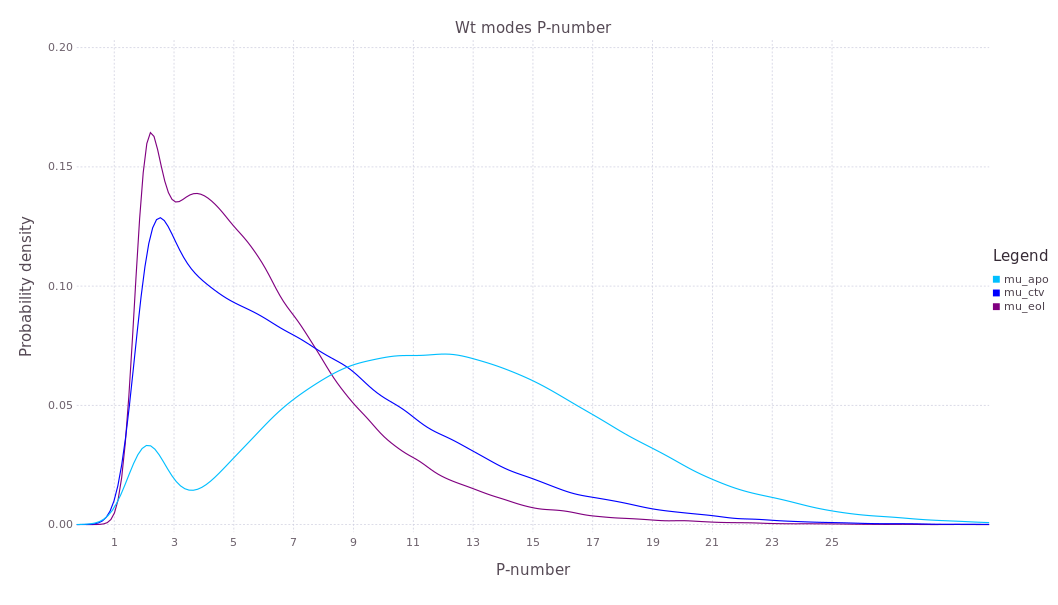

In [45]:
set_default_plot_size(28cm, 16cm)
df_pnum_mu_apo = DataFrame(transpose(pnum_mu_apo));
df_pnum_mu_ctv = DataFrame(transpose(pnum_mu_ctv));
df_pnum_mu_eol = DataFrame(transpose(pnum_mu_eol));

mu_apo_layer = layer(df_pnum_mu_apo, x="x1", Geom.density(), Theme(default_color=colorant"deepskyblue"))
mu_ctv_layer = layer(df_pnum_mu_ctv, x="x1", Geom.density(), Theme(default_color=colorant"blue"))
mu_eol_layer = layer(df_pnum_mu_eol, x="x1", Geom.density(), Theme(default_color=colorant"purple"))

pnum_hist_wt = plot(mu_apo_layer, mu_ctv_layer, mu_eol_layer,
Guide.xlabel("P-number"), Guide.ylabel("Probability density"), Guide.Title("Wt modes P-number"),
Guide.manual_color_key("Legend", ["mu_apo", "mu_ctv", "mu_eol"],
["deepskyblue", "blue", "purple"]),
Coord.Cartesian(xmin=0, xmax=30),
Guide.xticks(ticks = collect(1:2:25), orientation=:horizontal))

## Ahora obtengo los espacios esenciales a c/ frame, y en éstos me obtengo la frecuencia de aparición de c/ modo.

In [46]:
# Redondeo los pnumbers
round_pnum_mu_apo = convert(Array{Int64}, round(pnum_mu_apo))
round_pnum_mu_apo = reshape(round_pnum_mu_apo, size(round_pnum_mu_apo)[2])
round_pnum_mu_ctv = convert(Array{Int64}, round(pnum_mu_ctv))
round_pnum_mu_ctv = reshape(round_pnum_mu_ctv, size(round_pnum_mu_ctv)[2])
round_pnum_mu_eol = convert(Array{Int64}, round(pnum_mu_eol))
round_pnum_mu_eol = reshape(round_pnum_mu_eol, size(round_pnum_mu_eol)[2])

# Obtengo los valores absolutos de las proyecciones
projection_mu_apo1 = abs(projection_mu_apo);
projection_mu_ctv1 = abs(projection_mu_ctv);
projection_mu_eol1 = abs(projection_mu_eol);

# A c/ frame, ordeno los modos según su proyección con el vector diferencia correspondiente
index_mu_apo = mapslices(x->sortperm(x, rev = true), projection_mu_apo1, 1)
index_mu_ctv = mapslices(x->sortperm(x, rev = true), projection_mu_ctv1, 1)
index_mu_eol = mapslices(x->sortperm(x, rev = true), projection_mu_eol1, 1);

### Obtengo los índices de los pnum modos p/ c/ snapshot

In [47]:
# mu_apo
idx_subsp_mu_apo = Array{Array{Int64, 1}}(mu_apo_frames_cnt)
for i = 1:mu_apo_frames_cnt
    idx_subsp_mu_apo[i] = index_mu_apo[1:round_pnum_mu_apo[i], i]
end

# mu_ctv
idx_subsp_mu_ctv = Array{Array{Int64, 1}}(mu_ctv_frames_cnt)
for i = 1:mu_ctv_frames_cnt
    idx_subsp_mu_ctv[i] = index_mu_ctv[1:round_pnum_mu_ctv[i], i]
end

# mu_eol
idx_subsp_mu_eol = Array{Array{Int64, 1}}(mu_eol_frames_cnt)
for i = 1:mu_eol_frames_cnt
    idx_subsp_mu_eol[i] = index_mu_eol[1:round_pnum_mu_eol[i], i]
end

### Obtengo los histogramas de frecuencia de aparición de c/ modo en los subespacios esenciales de c/ frame.

In [48]:

# mu_apo
pmodes_index_mu_apo = Array{Int64, 1}(0)
counts_mu_apo = zeros(Int64, aa36)
for i = 1:mu_apo_frames_cnt
    for j = 1:round_pnum_mu_apo[i]
        counts_mu_apo[idx_subsp_mu_apo[i][j]] += 1
        push!(pmodes_index_mu_apo, idx_subsp_mu_apo[i][j])
    end
end

# mu_ctv
pmodes_index_mu_ctv = Array{Int64, 1}(0)
counts_mu_ctv = zeros(Int64, aa36)
for i = 1:mu_ctv_frames_cnt
    for j = 1:round_pnum_mu_ctv[i]
        counts_mu_ctv[idx_subsp_mu_ctv[i][j]] += 1
        push!(pmodes_index_mu_ctv, idx_subsp_mu_ctv[i][j])
    end
end

# mu_eol
pmodes_index_mu_eol = Array{Int64, 1}(0)
counts_mu_eol = zeros(Int64, aa36)
for i = 1:mu_eol_frames_cnt
    for j = 1:round_pnum_mu_eol[i]
        counts_mu_eol[idx_subsp_mu_eol[i][j]] += 1
        push!(pmodes_index_mu_eol, idx_subsp_mu_eol[i][j])
    end
end

# Todos los modos q aparecen al menos 1 vez en al menos 1 subespacio esencial,
# serán los modos del subespacio esencial general
pmodes_index_mu_apo = sort(unique(pmodes_index_mu_apo))
pmodes_index_mu_ctv = sort(unique(pmodes_index_mu_ctv))
pmodes_index_mu_eol = sort(unique(pmodes_index_mu_eol));

### Plots

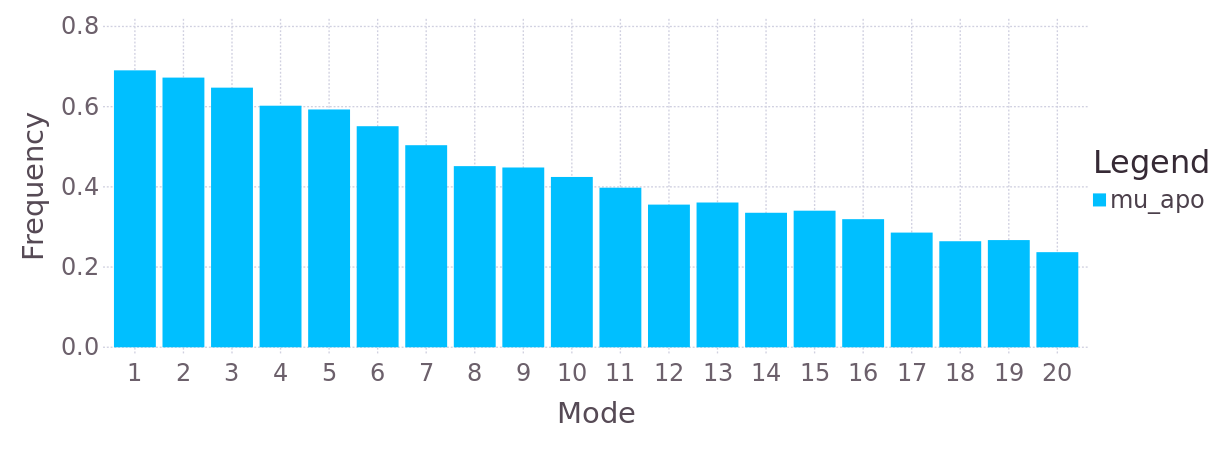

In [81]:
# mu_apo
df_hist_mu_apo = DataFrame(Frequency = counts_mu_apo ./ mu_apo_frames_cnt, Mode = collect(1:aa36), ID = "mu_apo")

plot(df_hist_mu_apo[1:20, :], y = "Frequency", x = "Mode", Geom.bar(position=:dodge),
Coord.cartesian(xmin = 0.5, xmax = 20.5), Guide.xticks(ticks = collect(1:20)),
Guide.manual_color_key("Legend", ["mu_apo"], ["deepskyblue"]),
Theme(default_color=colorant"Deepskyblue", bar_spacing = 5pt, grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

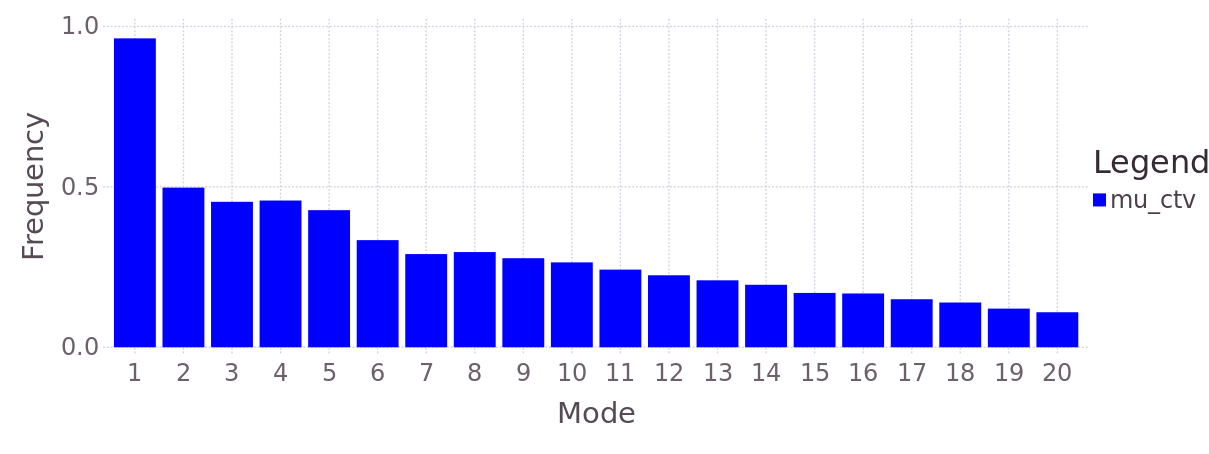

In [82]:
# mu_ctv
df_hist_mu_ctv = DataFrame(Frequency = counts_mu_ctv ./ mu_ctv_frames_cnt, Mode = collect(1:aa36), ID = "mu_ctv")

plot(df_hist_mu_ctv[1:20, :], y = "Frequency", x = "Mode", Geom.bar(position=:dodge),
Coord.cartesian(xmin = 0.5, xmax = 20.5), Guide.xticks(ticks = collect(1:20)),
Guide.manual_color_key("Legend", ["mu_ctv"], ["Blue"]),
Theme(default_color=colorant"Blue", bar_spacing = 5pt, grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

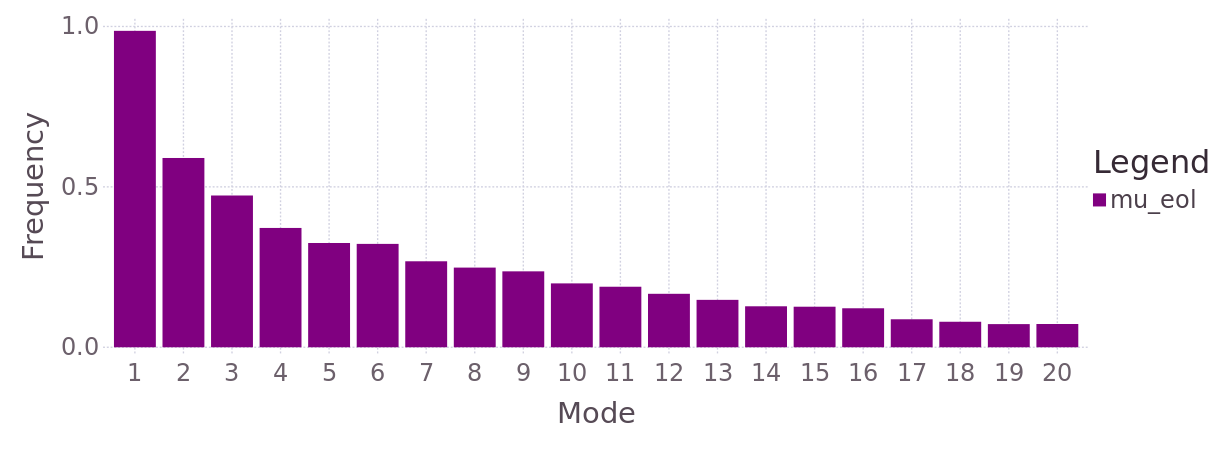

In [83]:
# mu_eol
df_hist_mu_eol = DataFrame(Frequency = counts_mu_eol ./ mu_eol_frames_cnt, Mode = collect(1:aa36), ID = "mu_eol");

plot(df_hist_mu_eol[1:20, :], y = "Frequency", x = "Mode", Geom.bar(position=:dodge),
Coord.cartesian(xmin = 0.5, xmax = 20.5), Guide.xticks(ticks = collect(1:20)),
Guide.manual_color_key("Legend", ["mu_eol"], ["Purple"]),
Theme(default_color=colorant"Purple", bar_spacing = 5pt, grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

# P number de c/ modo según SSE

### Preparo. Defino las estructuras secundarias

In [52]:
# Defino los Calphas de las structs secundarias
α1 = collect(1:19)
   l1 = collect(20:22)
α2 = collect(23:30)
    l2 = collect(31:38)
α3 = collect(39:51)
    l3 = collect(52:62)
α4 = collect(63:70)
    l4 = collect(71:75)
α5 = collect(76:86)
    l5 = collect(87:93)
α6 = collect(94:106)
    l6 = collect(107:110)
α7 = collect(111:114)

# Ahora los indices de sus coordenadas xyz
α13 = map(x -> x*3, repeat(α1, inner=[3])) - repeat([2, 1, 0], outer = [length(α1)])
α23 = map(x -> x*3, repeat(α2, inner=[3])) - repeat([2, 1, 0], outer = [length(α2)])
α33 = map(x -> x*3, repeat(α3, inner=[3])) - repeat([2, 1, 0], outer = [length(α3)])
α43 = map(x -> x*3, repeat(α4, inner=[3])) - repeat([2, 1, 0], outer = [length(α4)])
α53 = map(x -> x*3, repeat(α5, inner=[3])) - repeat([2, 1, 0], outer = [length(α5)])
α63 = map(x -> x*3, repeat(α6, inner=[3])) - repeat([2, 1, 0], outer = [length(α6)])
α73 = map(x -> x*3, repeat(α7, inner=[3])) - repeat([2, 1, 0], outer = [length(α7)]);

l13 = map(x -> x*3, repeat(l1, inner=[3])) - repeat([2, 1, 0], outer = [length(l1)])
l23 = map(x -> x*3, repeat(l2, inner=[3])) - repeat([2, 1, 0], outer = [length(l2)])
l33 = map(x -> x*3, repeat(l3, inner=[3])) - repeat([2, 1, 0], outer = [length(l3)])
l43 = map(x -> x*3, repeat(l4, inner=[3])) - repeat([2, 1, 0], outer = [length(l4)])
l53 = map(x -> x*3, repeat(l5, inner=[3])) - repeat([2, 1, 0], outer = [length(l5)])
l63 = map(x -> x*3, repeat(l6, inner=[3])) - repeat([2, 1, 0], outer = [length(l6)]);

sse_count = 13;

## mu_apo

In [86]:
# Obtengo los modos en gnm.
modes_gnm_mu_apo = tognm(modes_mu_apo)

# Defino subespacio esencial.
essential_subsp_mu_apo = modes_mu_apo[:, pmodes_index_mu_apo]
essential_subsp_gnm_mu_apo = modes_gnm_mu_apo[:, pmodes_index_mu_apo]

# Subsetteo el essential subspace segun SSE.
essential_subsp_gnm_α1_mu_apo = essential_subsp_gnm_mu_apo[α1, :]
essential_subsp_gnm_α2_mu_apo = essential_subsp_gnm_mu_apo[α2, :]
essential_subsp_gnm_α3_mu_apo = essential_subsp_gnm_mu_apo[α3, :]
essential_subsp_gnm_α4_mu_apo = essential_subsp_gnm_mu_apo[α4, :]
essential_subsp_gnm_α5_mu_apo = essential_subsp_gnm_mu_apo[α5, :]
essential_subsp_gnm_α6_mu_apo = essential_subsp_gnm_mu_apo[α6, :]
essential_subsp_gnm_α7_mu_apo = essential_subsp_gnm_mu_apo[α7, :]

essential_subsp_gnm_l1_mu_apo = essential_subsp_gnm_mu_apo[l1, :]
essential_subsp_gnm_l2_mu_apo = essential_subsp_gnm_mu_apo[l2, :]
essential_subsp_gnm_l3_mu_apo = essential_subsp_gnm_mu_apo[l3, :]
essential_subsp_gnm_l4_mu_apo = essential_subsp_gnm_mu_apo[l4, :]
essential_subsp_gnm_l5_mu_apo = essential_subsp_gnm_mu_apo[l5, :]
essential_subsp_gnm_l6_mu_apo = essential_subsp_gnm_mu_apo[l6, :]

# sse_mtx_mu_apo tiene las contribuciones a c/ SSE q hace c/u de los modos esenciales.
sse_mtx_mu_apo = vcat(sum((essential_subsp_gnm_α1_mu_apo.^2), 1),
                sum((essential_subsp_gnm_α2_mu_apo.^2), 1),
                sum((essential_subsp_gnm_α3_mu_apo.^2), 1),
                sum((essential_subsp_gnm_α4_mu_apo.^2), 1),
                sum((essential_subsp_gnm_α5_mu_apo.^2), 1),
                sum((essential_subsp_gnm_α6_mu_apo.^2), 1),
                sum((essential_subsp_gnm_α7_mu_apo.^2), 1),
                sum((essential_subsp_gnm_l1_mu_apo.^2), 1),
                sum((essential_subsp_gnm_l2_mu_apo.^2), 1),
                sum((essential_subsp_gnm_l3_mu_apo.^2), 1),
                sum((essential_subsp_gnm_l4_mu_apo.^2), 1),
                sum((essential_subsp_gnm_l5_mu_apo.^2), 1),
                sum((essential_subsp_gnm_l6_mu_apo.^2), 1))

# Saco los números de SSE q mueve c/ modo.
pnum_sse_mu_apo = mapslices(x -> 1/sum(x.^2), sse_mtx_mu_apo, 1);
pnum_sse_mu_apo = reshape(pnum_sse_mu_apo, length(pnum_sse_mu_apo));

## mu_ctv

In [87]:
# Obtengo los modos en gnm.
modes_gnm_mu_ctv = tognm(modes_mu_ctv)

# Defino subespacio esencial.
essential_subsp_mu_ctv = modes_mu_ctv[:, pmodes_index_mu_ctv]
essential_subsp_gnm_mu_ctv = modes_gnm_mu_ctv[:, pmodes_index_mu_ctv]

# Subsetteo el essential subspace segun SSE.
essential_subsp_gnm_α1_mu_ctv = essential_subsp_gnm_mu_ctv[α1, :]
essential_subsp_gnm_α2_mu_ctv = essential_subsp_gnm_mu_ctv[α2, :]
essential_subsp_gnm_α3_mu_ctv = essential_subsp_gnm_mu_ctv[α3, :]
essential_subsp_gnm_α4_mu_ctv = essential_subsp_gnm_mu_ctv[α4, :]
essential_subsp_gnm_α5_mu_ctv = essential_subsp_gnm_mu_ctv[α5, :]
essential_subsp_gnm_α6_mu_ctv = essential_subsp_gnm_mu_ctv[α6, :]
essential_subsp_gnm_α7_mu_ctv = essential_subsp_gnm_mu_ctv[α7, :]

essential_subsp_gnm_l1_mu_ctv = essential_subsp_gnm_mu_ctv[l1, :]
essential_subsp_gnm_l2_mu_ctv = essential_subsp_gnm_mu_ctv[l2, :]
essential_subsp_gnm_l3_mu_ctv = essential_subsp_gnm_mu_ctv[l3, :]
essential_subsp_gnm_l4_mu_ctv = essential_subsp_gnm_mu_ctv[l4, :]
essential_subsp_gnm_l5_mu_ctv = essential_subsp_gnm_mu_ctv[l5, :]
essential_subsp_gnm_l6_mu_ctv = essential_subsp_gnm_mu_ctv[l6, :]

# sse_mtx_mu_ctv tiene las contribuciones a c/ SSE q hace c/u de los modos esenciales.
sse_mtx_mu_ctv = vcat(sum((essential_subsp_gnm_α1_mu_ctv.^2), 1),
                sum((essential_subsp_gnm_α2_mu_ctv.^2), 1),
                sum((essential_subsp_gnm_α3_mu_ctv.^2), 1),
                sum((essential_subsp_gnm_α4_mu_ctv.^2), 1),
                sum((essential_subsp_gnm_α5_mu_ctv.^2), 1),
                sum((essential_subsp_gnm_α6_mu_ctv.^2), 1),
                sum((essential_subsp_gnm_α7_mu_ctv.^2), 1),
                sum((essential_subsp_gnm_l1_mu_ctv.^2), 1),
                sum((essential_subsp_gnm_l2_mu_ctv.^2), 1),
                sum((essential_subsp_gnm_l3_mu_ctv.^2), 1),
                sum((essential_subsp_gnm_l4_mu_ctv.^2), 1),
                sum((essential_subsp_gnm_l5_mu_ctv.^2), 1),
                sum((essential_subsp_gnm_l6_mu_ctv.^2), 1))

# Saco los números de SSE q mueve c/ modo.
pnum_sse_mu_ctv = mapslices(x -> 1/sum(x.^2), sse_mtx_mu_ctv, 1);
pnum_sse_mu_ctv = reshape(pnum_sse_mu_ctv, length(pnum_sse_mu_ctv));


## mu_eol

In [88]:
# Obtengo los modos en gnm.
modes_gnm_mu_eol = tognm(modes_mu_eol)

# Defino subespacio esencial.
essential_subsp_mu_eol = modes_mu_eol[:, pmodes_index_mu_eol]
essential_subsp_gnm_mu_eol = modes_gnm_mu_eol[:, pmodes_index_mu_eol]

# Subsetteo el essential subspace segun SSE.
essential_subsp_gnm_α1_mu_eol = essential_subsp_gnm_mu_eol[α1, :]
essential_subsp_gnm_α2_mu_eol = essential_subsp_gnm_mu_eol[α2, :]
essential_subsp_gnm_α3_mu_eol = essential_subsp_gnm_mu_eol[α3, :]
essential_subsp_gnm_α4_mu_eol = essential_subsp_gnm_mu_eol[α4, :]
essential_subsp_gnm_α5_mu_eol = essential_subsp_gnm_mu_eol[α5, :]
essential_subsp_gnm_α6_mu_eol = essential_subsp_gnm_mu_eol[α6, :]
essential_subsp_gnm_α7_mu_eol = essential_subsp_gnm_mu_eol[α7, :]

essential_subsp_gnm_l1_mu_eol = essential_subsp_gnm_mu_eol[l1, :]
essential_subsp_gnm_l2_mu_eol = essential_subsp_gnm_mu_eol[l2, :]
essential_subsp_gnm_l3_mu_eol = essential_subsp_gnm_mu_eol[l3, :]
essential_subsp_gnm_l4_mu_eol = essential_subsp_gnm_mu_eol[l4, :]
essential_subsp_gnm_l5_mu_eol = essential_subsp_gnm_mu_eol[l5, :]
essential_subsp_gnm_l6_mu_eol = essential_subsp_gnm_mu_eol[l6, :]

# sse_mtx_mu_eol tiene las contribuciones a c/ SSE q hace c/u de los modos esenciales.
sse_mtx_mu_eol = vcat(sum((essential_subsp_gnm_α1_mu_eol.^2), 1),
                sum((essential_subsp_gnm_α2_mu_eol.^2), 1),
                sum((essential_subsp_gnm_α3_mu_eol.^2), 1),
                sum((essential_subsp_gnm_α4_mu_eol.^2), 1),
                sum((essential_subsp_gnm_α5_mu_eol.^2), 1),
                sum((essential_subsp_gnm_α6_mu_eol.^2), 1),
                sum((essential_subsp_gnm_α7_mu_eol.^2), 1),
                sum((essential_subsp_gnm_l1_mu_eol.^2), 1),
                sum((essential_subsp_gnm_l2_mu_eol.^2), 1),
                sum((essential_subsp_gnm_l3_mu_eol.^2), 1),
                sum((essential_subsp_gnm_l4_mu_eol.^2), 1),
                sum((essential_subsp_gnm_l5_mu_eol.^2), 1),
                sum((essential_subsp_gnm_l6_mu_eol.^2), 1))

# Saco los números de SSE q mueve c/ modo.
pnum_sse_mu_eol = mapslices(x -> 1/sum(x.^2), sse_mtx_mu_eol, 1);
pnum_sse_mu_eol = reshape(pnum_sse_mu_eol, length(pnum_sse_mu_eol));

### Plot!

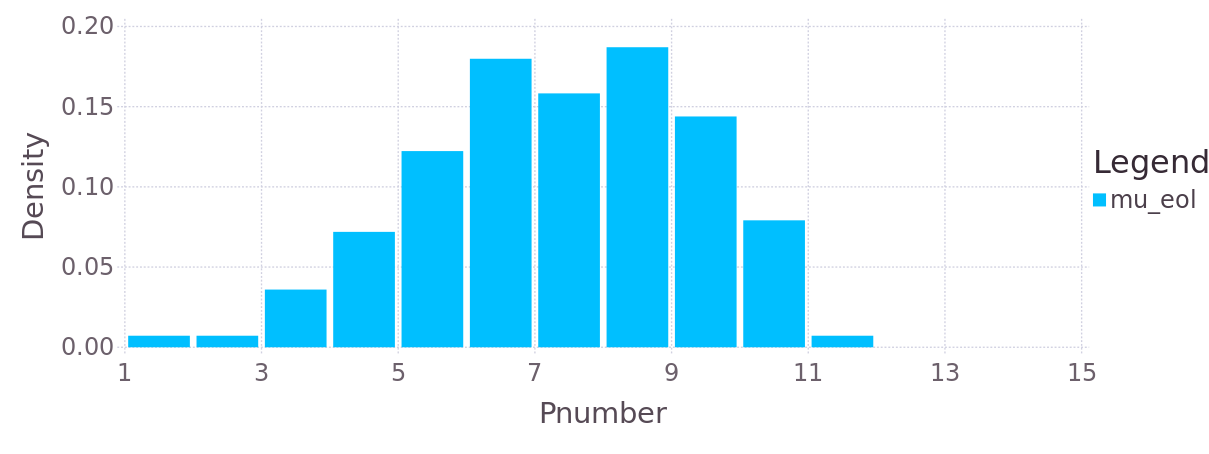

In [89]:
# Get the histogram.
weigths = repeat([1], inner = [length(pnum_sse_mu_apo)])
bins = collect(1:sse_count)
hist_counts_pnum_sse_mu_apo, bins_counts_pnum_sse_mu_apo = WeightedHist(pnum_sse_mu_apo, bins, weigths, true)

# Compile into a dataframe.
df_hist_mu_apo = DataFrame(Density = hist_counts_pnum_sse_mu_apo, Pnumber = bins_counts_pnum_sse_mu_apo)

plot(df_hist_mu_apo, x = "Pnumber", y = "Density", Geom.bar(position=:dodge),
Coord.cartesian(xmin = 1, xmax = 15), Guide.xticks(ticks = collect(1:2:15)),
Guide.manual_color_key("Legend", ["mu_eol"], ["Deepskyblue"]),
Theme(default_color=colorant"Deepskyblue", bar_spacing = 5pt, grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

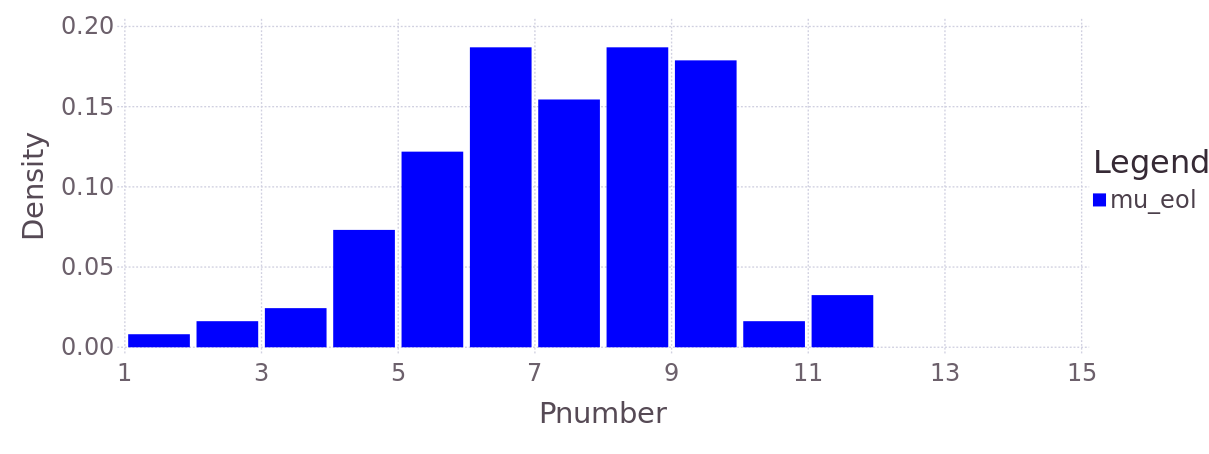

In [90]:
# Get the histogram.
weigths = repeat([1], inner = [length(pnum_sse_mu_ctv)])
bins = collect(1:sse_count)
hist_counts_pnum_sse_mu_ctv, bins_counts_pnum_sse_mu_ctv = WeightedHist(pnum_sse_mu_ctv, bins, weigths, true)

# Compile into a dataframe.
df_hist_mu_ctv = DataFrame(Density = hist_counts_pnum_sse_mu_ctv, Pnumber = bins_counts_pnum_sse_mu_ctv)

plot(df_hist_mu_ctv, x = "Pnumber", y = "Density", Geom.bar(position=:dodge),
Coord.cartesian(xmin = 1, xmax = 15), Guide.xticks(ticks = collect(1:2:15)),
Guide.manual_color_key("Legend", ["mu_eol"], ["Blue"]),
Theme(default_color=colorant"Blue", bar_spacing = 5pt, grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

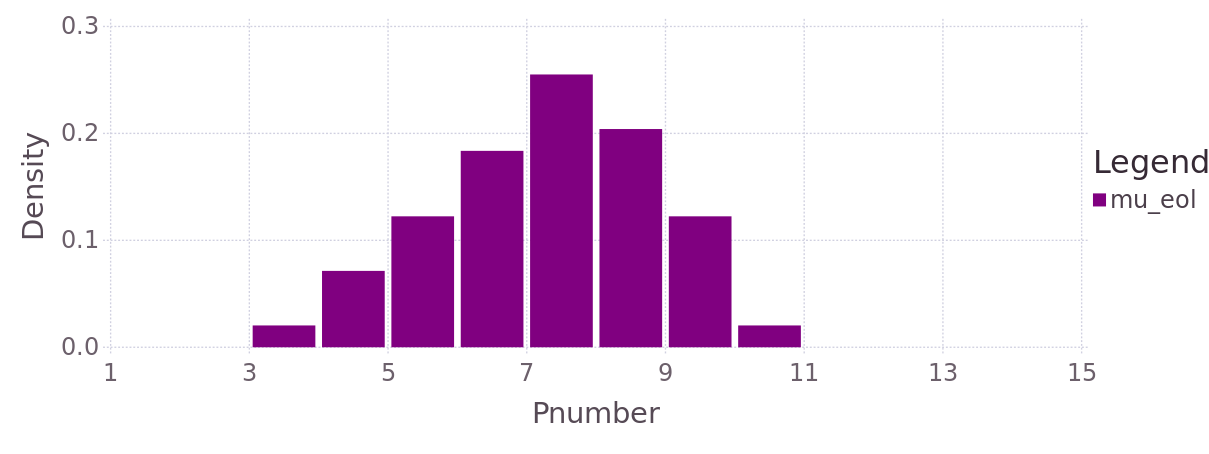

In [91]:
# Get the histogram.
weigths = repeat([1], inner = [length(pnum_sse_mu_eol)])
bins = collect(1:sse_count)
hist_counts_pnum_sse_mu_eol, bins_counts_pnum_sse_mu_eol = WeightedHist(pnum_sse_mu_eol, bins, weigths, true)

# Compile into a dataframe.
df_hist_mu_eol = DataFrame(Density = hist_counts_pnum_sse_mu_eol, Pnumber = bins_counts_pnum_sse_mu_eol)

plot(df_hist_mu_eol, x = "Pnumber", y = "Density", Geom.bar(position=:dodge),
Coord.cartesian(xmin = 1, xmax = 15), Guide.xticks(ticks = collect(1:2:15)),
Guide.manual_color_key("Legend", ["mu_eol"], ["Purple"]),
Theme(default_color=colorant"Purple", bar_spacing = 5pt, grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

# Ahora hago SSE pero hélices y loops por separado

In [92]:
# Primero tengo q obtener nuevos indices p/ las hélices y los loops
# hélices
hα13 = collect(1: length(α13))
hα23 = collect(hα13[end]+1: hα13[end]+length(α23))
hα33 = collect(hα23[end]+1: hα23[end]+length(α33))
hα43 = collect(hα33[end]+1: hα33[end]+length(α43))
hα53 = collect(hα43[end]+1: hα43[end]+length(α53))
hα63 = collect(hα53[end]+1: hα53[end]+length(α63))
hα73 = collect(hα63[end]+1: hα63[end]+length(α73));

## helices

## mu_apo

In [93]:
# Preparo variables
# subsetteo el subespacio esencial q corresponde a las hélices
αnorm_essential_subsp_mu_apo = [essential_subsp_α1_mu_apo; essential_subsp_α2_mu_apo; essential_subsp_α3_mu_apo; 
    essential_subsp_α4_mu_apo; essential_subsp_α5_mu_apo; essential_subsp_α6_mu_apo; essential_subsp_α7_mu_apo];
# lo renormalizo
αnorm_essential_subsp_mu_apo = mapslices(x -> x/norm(x), αnorm_essential_subsp_mu_apo, 1)
# y ahora si, separo los subespacios de c/ hélice
essential_subsp_α1_mu_apo = αnorm_essential_subsp_mu_apo[hα13, :]
essential_subsp_α2_mu_apo = αnorm_essential_subsp_mu_apo[hα23, :]
essential_subsp_α3_mu_apo = αnorm_essential_subsp_mu_apo[hα33, :]
essential_subsp_α4_mu_apo = αnorm_essential_subsp_mu_apo[hα43, :]
essential_subsp_α5_mu_apo = αnorm_essential_subsp_mu_apo[hα53, :]
essential_subsp_α6_mu_apo = αnorm_essential_subsp_mu_apo[hα63, :]
essential_subsp_α7_mu_apo = αnorm_essential_subsp_mu_apo[hα73, :]

# 1era parte p/ obtener el pnumber
α1_mtx_mu_apo = sum((essential_subsp_α1_mu_apo.^2), 1).^2
α2_mtx_mu_apo = sum((essential_subsp_α2_mu_apo.^2), 1).^2
α3_mtx_mu_apo = sum((essential_subsp_α3_mu_apo.^2), 1).^2
α4_mtx_mu_apo = sum((essential_subsp_α4_mu_apo.^2), 1).^2
α5_mtx_mu_apo = sum((essential_subsp_α5_mu_apo.^2), 1).^2
α6_mtx_mu_apo = sum((essential_subsp_α6_mu_apo.^2), 1).^2
α7_mtx_mu_apo = sum((essential_subsp_α7_mu_apo.^2), 1).^2

# junto todo en una lista
sse_mu_apo = Array{Float64}[α1_mtx_mu_apo, α2_mtx_mu_apo, α3_mtx_mu_apo, α4_mtx_mu_apo, α5_mtx_mu_apo,
    α6_mtx_mu_apo, α7_mtx_mu_apo]
# Preparo variable
pnum_sse_mu_apo = Array{Float64}(essential_aa36_mu_apo)

# Saco los números de SSE q mueve c/ modo
for i = 1:essential_aa36_mu_apo
    j=1
    temp = 0
    for sse in sse_mu_apo
        temp = temp + sse[i]  
    end
    pnum_sse_mu_apo[i] = 1 / temp
end

LoadError: UndefVarError: essential_subsp_α1_mu_apo not defined

## mu_ctv

In [94]:
# Preparo variables
# subsetteo el subespacio esencial q corresponde a las hélices
αnorm_essential_subsp_mu_ctv = [essential_subsp_α1_mu_ctv; essential_subsp_α2_mu_ctv; essential_subsp_α3_mu_ctv;
    essential_subsp_α4_mu_ctv; essential_subsp_α5_mu_ctv; essential_subsp_α6_mu_ctv; essential_subsp_α7_mu_ctv];
# lo renormalizo
αnorm_essential_subsp_mu_ctv = mapslices(x -> x/norm(x), αnorm_essential_subsp_mu_ctv, 1)
# y ahora si, separo los subespacios de c/ hélice
essential_subsp_α1_mu_ctv = αnorm_essential_subsp_mu_ctv[hα13, :]
essential_subsp_α2_mu_ctv = αnorm_essential_subsp_mu_ctv[hα23, :]
essential_subsp_α3_mu_ctv = αnorm_essential_subsp_mu_ctv[hα33, :]
essential_subsp_α4_mu_ctv = αnorm_essential_subsp_mu_ctv[hα43, :]
essential_subsp_α5_mu_ctv = αnorm_essential_subsp_mu_ctv[hα53, :]
essential_subsp_α6_mu_ctv = αnorm_essential_subsp_mu_ctv[hα63, :]
essential_subsp_α7_mu_ctv = αnorm_essential_subsp_mu_ctv[hα73, :]

# 1era parte p/ obtener el pnumber
α1_mtx_mu_ctv = sum((essential_subsp_α1_mu_ctv.^2), 1).^2
α2_mtx_mu_ctv = sum((essential_subsp_α2_mu_ctv.^2), 1).^2
α3_mtx_mu_ctv = sum((essential_subsp_α3_mu_ctv.^2), 1).^2
α4_mtx_mu_ctv = sum((essential_subsp_α4_mu_ctv.^2), 1).^2
α5_mtx_mu_ctv = sum((essential_subsp_α5_mu_ctv.^2), 1).^2
α6_mtx_mu_ctv = sum((essential_subsp_α6_mu_ctv.^2), 1).^2
α7_mtx_mu_ctv = sum((essential_subsp_α7_mu_ctv.^2), 1).^2

# junto todo en una lista
sse_mu_ctv = Array{Float64}[α1_mtx_mu_ctv, α2_mtx_mu_ctv, α3_mtx_mu_ctv, α4_mtx_mu_ctv, α5_mtx_mu_ctv,
    α6_mtx_mu_ctv, α7_mtx_mu_ctv]
pnum_sse_mu_ctv = Array{Float64}(essential_aa36_mu_ctv)

# Saco los números de SSE q mueve c/ modo
for i = 1:essential_aa36_mu_ctv
    j=1
    temp = 0
    for sse in sse_mu_ctv
        temp = temp + sse[i]  
    end
    pnum_sse_mu_ctv[i] = 1 / temp
end



LoadError: UndefVarError: essential_subsp_α1_mu_ctv not defined

## mu_eol

In [95]:
# Preparo variables
# subsetteo el subespacio esencial q corresponde a las hélices
αnorm_essential_subsp_mu_eol = [essential_subsp_α1_mu_eol; essential_subsp_α2_mu_eol; essential_subsp_α3_mu_eol;
    essential_subsp_α4_mu_eol; essential_subsp_α5_mu_eol; essential_subsp_α6_mu_eol; essential_subsp_α7_mu_eol];
# lo renormalizo
αnorm_essential_subsp_mu_eol = mapslices(x -> x/norm(x), αnorm_essential_subsp_mu_eol, 1)
# y ahora si, separo los subespacios de c/ hélice
essential_subsp_α1_mu_eol = αnorm_essential_subsp_mu_eol[hα13, :]
essential_subsp_α2_mu_eol = αnorm_essential_subsp_mu_eol[hα23, :]
essential_subsp_α3_mu_eol = αnorm_essential_subsp_mu_eol[hα33, :]
essential_subsp_α4_mu_eol = αnorm_essential_subsp_mu_eol[hα43, :]
essential_subsp_α5_mu_eol = αnorm_essential_subsp_mu_eol[hα53, :]
essential_subsp_α6_mu_eol = αnorm_essential_subsp_mu_eol[hα63, :]
essential_subsp_α7_mu_eol = αnorm_essential_subsp_mu_eol[hα73, :]

# 1era parte p/ obtener el pnumber
α1_mtx_mu_eol = sum((essential_subsp_α1_mu_eol.^2), 1).^2
α2_mtx_mu_eol = sum((essential_subsp_α2_mu_eol.^2), 1).^2
α3_mtx_mu_eol = sum((essential_subsp_α3_mu_eol.^2), 1).^2
α4_mtx_mu_eol = sum((essential_subsp_α4_mu_eol.^2), 1).^2
α5_mtx_mu_eol = sum((essential_subsp_α5_mu_eol.^2), 1).^2
α6_mtx_mu_eol = sum((essential_subsp_α6_mu_eol.^2), 1).^2
α7_mtx_mu_eol = sum((essential_subsp_α7_mu_eol.^2), 1).^2

# junto todo en una lista
sse_mu_eol = Array{Float64}[α1_mtx_mu_eol, α2_mtx_mu_eol, α3_mtx_mu_eol, α4_mtx_mu_eol, α5_mtx_mu_eol,
    α6_mtx_mu_eol, α7_mtx_mu_eol]
# Preparo variable
pnum_sse_mu_eol = Array{Float64}(essential_aa36_mu_eol)

# Saco los números de SSE q mueve c/ modo
for i = 1:essential_aa36_mu_eol
    j=1
    temp = 0
    for sse in sse_mu_eol
        temp = temp + sse[i]  
    end
    pnum_sse_mu_eol[i] = 1 / temp
end

LoadError: UndefVarError: essential_subsp_α1_mu_eol not defined

## Plot de helices

In [96]:
# Hago los histogramas
pnum_sse_mu_apo = convert(Array{Int64}, round(pnum_sse_mu_apo))
sse_xmax_mu_apo, sse_freq_mu_apo = hist(pnum_sse_mu_apo, collect(1:1:8))
sse_freq_mu_apo = sse_freq_mu_apo / essential_aa36_mu_apo
sse_xmin_mu_apo = sse_xmax_mu_apo .- .33
pop!(sse_xmin_mu_apo)
pop!(sse_xmax_mu_apo)

pnum_sse_mu_ctv = convert(Array{Int64}, round(pnum_sse_mu_ctv))
sse_xmax_mu_ctv, sse_freq_mu_ctv = hist(pnum_sse_mu_ctv, collect(1:1:8))
sse_freq_mu_ctv = sse_freq_mu_ctv / essential_aa36_mu_ctv
sse_xmin_mu_ctv = sse_xmax_mu_ctv .- .66
pop!(sse_xmin_mu_ctv)
pop!(sse_xmax_mu_ctv)

pnum_sse_mu_eol = convert(Array{Int64}, round(pnum_sse_mu_eol))
sse_xmax_mu_eol, sse_freq_mu_eol = hist(pnum_sse_mu_eol, collect(1:1:8))
sse_freq_mu_eol = sse_freq_mu_eol / essential_aa36_mu_eol
sse_xmin_mu_eol = sse_xmax_mu_eol .- 1
pop!(sse_xmin_mu_eol)
pop!(sse_xmax_mu_eol)


# Los junto en un dataframe
names = [repeat(["mu_apo"], inner=[7]); repeat(["mu_ctv"], inner=[7]); repeat(["mu_eol"], inner=[7])]
datos = [sse_freq_mu_apo; sse_freq_mu_ctv; sse_freq_mu_eol ]
xmins = [sse_xmin_mu_apo; sse_xmin_mu_ctv; sse_xmin_mu_eol]
xmaxs = [sse_xmax_mu_apo; sse_xmax_mu_ctv; sse_xmax_mu_eol]
df_datos_helices = DataFrame(Legend=names, RelativeProbability=datos, xmin=xmins, xmax=xmaxs+.5) # acomodo el xmaxs

pnum_helices_hist = plot(df_datos_helices, x="xmax", y="RelativeProbability", color="Legend", 
Geom.bar(position=:dodge),
Scale.x_continuous,
Theme(bar_spacing=3pt, default_color=colorant"black"),
Guide.Title("P-number in terms of helices"),
Coord.Cartesian(xmin=0, xmax=8),
Guide.xticks(ticks = collect(1:1:8), orientation=:horizontal),
Guide.yticks(ticks = collect(0.0:0.1:0.4), orientation=:horizontal), 
Guide.xlabel("helices participation number"), Guide.ylabel("relative probability"))

LoadError: UndefVarError: essential_aa36_mu_apo not defined

##  loops

In [97]:
# loops
ll13 = collect(1: length(l13))
ll23 = collect(ll13[end]+1: ll13[end]+length(l23))
ll33 = collect(ll23[end]+1: ll23[end]+length(l33))
ll43 = collect(ll33[end]+1: ll33[end]+length(l43))
ll53 = collect(ll43[end]+1: ll43[end]+length(l53))
ll63 = collect(ll53[end]+1: ll53[end]+length(l63));

## mu_apo

In [98]:
# Preparo variables
# subsetteo el subespacio esencial q corresponde a las hélices
lnorm_essential_subsp_mu_apo = [essential_subsp_l1_mu_apo; essential_subsp_l2_mu_apo; essential_subsp_l3_mu_apo;
    essential_subsp_l4_mu_apo; essential_subsp_l5_mu_apo; essential_subsp_l6_mu_apo];
# lo renormalizo
lnorm_essential_subsp_mu_apo = mapslices(x -> x/norm(x), lnorm_essential_subsp_mu_apo, 1)
# y ahora si, separo los subespacios de c/ hélice
essential_subsp_l1_mu_apo = lnorm_essential_subsp_mu_apo[ll13, :]
essential_subsp_l2_mu_apo = lnorm_essential_subsp_mu_apo[ll23, :]
essential_subsp_l3_mu_apo = lnorm_essential_subsp_mu_apo[ll33, :]
essential_subsp_l4_mu_apo = lnorm_essential_subsp_mu_apo[ll43, :]
essential_subsp_l5_mu_apo = lnorm_essential_subsp_mu_apo[ll53, :]
essential_subsp_l6_mu_apo = lnorm_essential_subsp_mu_apo[ll63, :]

# 1era parte p/ obtener el pnumber
l1_mtx_mu_apo = sum((essential_subsp_l1_mu_apo.^2), 1).^2
l2_mtx_mu_apo = sum((essential_subsp_l2_mu_apo.^2), 1).^2
l3_mtx_mu_apo = sum((essential_subsp_l3_mu_apo.^2), 1).^2
l4_mtx_mu_apo = sum((essential_subsp_l4_mu_apo.^2), 1).^2
l5_mtx_mu_apo = sum((essential_subsp_l5_mu_apo.^2), 1).^2
l6_mtx_mu_apo = sum((essential_subsp_l6_mu_apo.^2), 1).^2

# junto todo en una lista
sse_mu_apo = Array{Float64}[l1_mtx_mu_apo, l2_mtx_mu_apo, l3_mtx_mu_apo, l4_mtx_mu_apo, l5_mtx_mu_apo,
    l6_mtx_mu_apo]
# Preparo variable
pnum_sse_mu_apo = Array{Float64}(essential_aa36_mu_apo)

# Saco los números de SSE q mueve c/ modo
for i = 1:essential_aa36_mu_apo
    j=1
    temp = 0
    for sse in sse_mu_apo
        temp = temp + sse[i]
    end
    pnum_sse_mu_apo[i] = 1 / temp
end

LoadError: UndefVarError: essential_subsp_l1_mu_apo not defined

## mu_ctv

In [99]:
# Preparo variables
# subsetteo el subespacio esencial q corresponde a las hélices
lnorm_essential_subsp_mu_ctv = [essential_subsp_l1_mu_ctv; essential_subsp_l2_mu_ctv; essential_subsp_l3_mu_ctv;
    essential_subsp_l4_mu_ctv; essential_subsp_l5_mu_ctv; essential_subsp_l6_mu_ctv];
# lo renormalizo
lnorm_essential_subsp_mu_ctv = mapslices(x -> x/norm(x), lnorm_essential_subsp_mu_ctv, 1)
# y ahora si, separo los subespacios de c/ hélice
essential_subsp_l1_mu_ctv = lnorm_essential_subsp_mu_ctv[ll13, :]
essential_subsp_l2_mu_ctv = lnorm_essential_subsp_mu_ctv[ll23, :]
essential_subsp_l3_mu_ctv = lnorm_essential_subsp_mu_ctv[ll33, :]
essential_subsp_l4_mu_ctv = lnorm_essential_subsp_mu_ctv[ll43, :]
essential_subsp_l5_mu_ctv = lnorm_essential_subsp_mu_ctv[ll53, :]
essential_subsp_l6_mu_ctv = lnorm_essential_subsp_mu_ctv[ll63, :]

# 1era parte p/ obtener el pnumber
l1_mtx_mu_ctv = sum((essential_subsp_l1_mu_ctv.^2), 1).^2
l2_mtx_mu_ctv = sum((essential_subsp_l2_mu_ctv.^2), 1).^2
l3_mtx_mu_ctv = sum((essential_subsp_l3_mu_ctv.^2), 1).^2
l4_mtx_mu_ctv = sum((essential_subsp_l4_mu_ctv.^2), 1).^2
l5_mtx_mu_ctv = sum((essential_subsp_l5_mu_ctv.^2), 1).^2
l6_mtx_mu_ctv = sum((essential_subsp_l6_mu_ctv.^2), 1).^2

# junto todo en una lista
sse_mu_ctv = Array{Float64}[l1_mtx_mu_ctv, l2_mtx_mu_ctv, l3_mtx_mu_ctv, l4_mtx_mu_ctv, l5_mtx_mu_ctv,
    l6_mtx_mu_ctv]
# Preparo variable
pnum_sse_mu_ctv = Array{Float64}(essential_aa36_mu_ctv)

# Saco los números de SSE q mueve c/ modo
for i = 1:essential_aa36_mu_ctv
    j=1
    temp = 0
    for sse in sse_mu_ctv
        temp = temp + sse[i]
    end
    pnum_sse_mu_ctv[i] = 1 / temp
end

LoadError: UndefVarError: essential_subsp_l1_mu_ctv not defined

## mu_eol

In [100]:
# Preparo variables
# subsetteo el subespacio esencial q corresponde a las hélices
lnorm_essential_subsp_mu_eol = [essential_subsp_l1_mu_eol; essential_subsp_l2_mu_eol; essential_subsp_l3_mu_eol;
    essential_subsp_l4_mu_eol; essential_subsp_l5_mu_eol; essential_subsp_l6_mu_eol];
# lo renormalizo
lnorm_essential_subsp_mu_eol = mapslices(x -> x/norm(x), lnorm_essential_subsp_mu_eol, 1)
# y ahora si, separo los subespacios de c/ hélice
essential_subsp_l1_mu_eol = lnorm_essential_subsp_mu_eol[ll13, :]
essential_subsp_l2_mu_eol = lnorm_essential_subsp_mu_eol[ll23, :]
essential_subsp_l3_mu_eol = lnorm_essential_subsp_mu_eol[ll33, :]
essential_subsp_l4_mu_eol = lnorm_essential_subsp_mu_eol[ll43, :]
essential_subsp_l5_mu_eol = lnorm_essential_subsp_mu_eol[ll53, :]
essential_subsp_l6_mu_eol = lnorm_essential_subsp_mu_eol[ll63, :]

# 1era parte p/ obtener el pnumber
l1_mtx_mu_eol = sum((essential_subsp_l1_mu_eol.^2), 1).^2
l2_mtx_mu_eol = sum((essential_subsp_l2_mu_eol.^2), 1).^2
l3_mtx_mu_eol = sum((essential_subsp_l3_mu_eol.^2), 1).^2
l4_mtx_mu_eol = sum((essential_subsp_l4_mu_eol.^2), 1).^2
l5_mtx_mu_eol = sum((essential_subsp_l5_mu_eol.^2), 1).^2
l6_mtx_mu_eol = sum((essential_subsp_l6_mu_eol.^2), 1).^2

# junto todo en una lista
sse_mu_eol = Array{Float64}[l1_mtx_mu_eol, l2_mtx_mu_eol, l3_mtx_mu_eol, l4_mtx_mu_eol, l5_mtx_mu_eol,
    l6_mtx_mu_eol]
# Preparo variable
pnum_sse_mu_eol = Array{Float64}(essential_aa36_mu_eol)

# Saco los números de SSE q mueve c/ modo
for i = 1:essential_aa36_mu_eol
    j=1
    temp = 0
    for sse in sse_mu_eol
        temp = temp + sse[i]
    end
    pnum_sse_mu_eol[i] = 1 / temp
end


LoadError: UndefVarError: essential_subsp_l1_mu_eol not defined

## Plot de loops

In [101]:
# otro plotteo

# Hago los histogramas
pnum_sse_mu_apo = convert(Array{Int64}, round(pnum_sse_mu_apo))
sse_xmax_mu_apo, sse_freq_mu_apo = hist(pnum_sse_mu_apo, collect(1:1:7))
sse_freq_mu_apo = sse_freq_mu_apo / essential_aa36_mu_apo
sse_xmin_mu_apo = sse_xmax_mu_apo .- .33
pop!(sse_xmin_mu_apo)
pop!(sse_xmax_mu_apo)

pnum_sse_mu_ctv = convert(Array{Int64}, round(pnum_sse_mu_ctv))
sse_xmax_mu_ctv, sse_freq_mu_ctv = hist(pnum_sse_mu_ctv, collect(1:1:7))
sse_freq_mu_ctv = sse_freq_mu_ctv / essential_aa36_mu_ctv
sse_xmin_mu_ctv = sse_xmax_mu_ctv .- .66
pop!(sse_xmin_mu_ctv)
pop!(sse_xmax_mu_ctv)

pnum_sse_mu_eol = convert(Array{Int64}, round(pnum_sse_mu_eol))
sse_xmax_mu_eol, sse_freq_mu_eol = hist(pnum_sse_mu_eol, collect(1:1:7))
sse_freq_mu_eol = sse_freq_mu_eol / essential_aa36_mu_eol
sse_xmin_mu_eol = sse_xmax_mu_eol .- 1
pop!(sse_xmin_mu_eol)
pop!(sse_xmax_mu_eol)


# Los junto en un dataframe
names = [repeat(["mu_apo"], inner=[6]); repeat(["mu_ctv"], inner=[6]); repeat(["mu_eol"], inner=[6])]
datos = [sse_freq_mu_apo; sse_freq_mu_ctv; sse_freq_mu_eol ]
xmins = [sse_xmin_mu_apo; sse_xmin_mu_ctv; sse_xmin_mu_eol]
xmaxs = [sse_xmax_mu_apo; sse_xmax_mu_ctv; sse_xmax_mu_eol]
df_datos_loops = DataFrame(Legend=names, RelativeProbability=datos, xmin=xmins, xmax=xmaxs+.5) # acomodo el xmaxs

#pnum_loops_hist = plot(df_datos_loops, xmin="xmin", xmax="xmax", y="RelativeProbability", color="Legend",
pnum_loops_hist = plot(df_datos_loops, x="xmax", y="RelativeProbability", color="Legend",
Geom.bar(position=:dodge),
Scale.x_continuous,
Theme(bar_spacing=3pt, default_color=colorant"black"),
Guide.Title("P-number in terms of loops"),
Coord.Cartesian(xmin=0, xmax=7),
Guide.xticks(ticks = collect(1:1:6), orientation=:horizontal),
Guide.yticks(ticks = collect(0.0:0.1:0.5), orientation=:horizontal), 
Guide.xlabel("loops participation number"), Guide.ylabel("relative probability"))

LoadError: UndefVarError: essential_aa36_mu_apo not defined

In [102]:
draw(PDF("loops-vs-helices_hist_wt2.pdf", 45cm, 15cm), hstack(pnum_helices_hist, pnum_loops_hist));

LoadError: UndefVarError: pnum_helices_hist not defined

# Tabla de comparación

## Avg contributions de c/ SSE al subespacio

In [103]:
# Subsetteo el essential subspace segun SSE
essential_subsp_α1_mu_apo = essential_subsp_mu_apo[α13, :]
essential_subsp_α2_mu_apo = essential_subsp_mu_apo[α23, :]
essential_subsp_α3_mu_apo = essential_subsp_mu_apo[α33, :]
essential_subsp_α4_mu_apo = essential_subsp_mu_apo[α43, :]
essential_subsp_α5_mu_apo = essential_subsp_mu_apo[α53, :]
essential_subsp_α6_mu_apo = essential_subsp_mu_apo[α63, :]
essential_subsp_α7_mu_apo = essential_subsp_mu_apo[α73, :]

essential_subsp_l1_mu_apo = essential_subsp_mu_apo[l13, :]
essential_subsp_l2_mu_apo = essential_subsp_mu_apo[l23, :]
essential_subsp_l3_mu_apo = essential_subsp_mu_apo[l33, :]
essential_subsp_l4_mu_apo = essential_subsp_mu_apo[l43, :]
essential_subsp_l5_mu_apo = essential_subsp_mu_apo[l53, :]
essential_subsp_l6_mu_apo = essential_subsp_mu_apo[l63, :]

# compilo todo en una mtx
contribution_mu_apo = [ sum((essential_subsp_α1_mu_apo.^2), 1).^2;
α2_mtx_mu_apo = sum((essential_subsp_α2_mu_apo.^2), 1).^2; α3_mtx_mu_apo = sum((essential_subsp_α3_mu_apo.^2), 1).^2;
α4_mtx_mu_apo = sum((essential_subsp_α4_mu_apo.^2), 1).^2; α5_mtx_mu_apo = sum((essential_subsp_α5_mu_apo.^2), 1).^2;
α6_mtx_mu_apo = sum((essential_subsp_α6_mu_apo.^2), 1).^2; α7_mtx_mu_apo = sum((essential_subsp_α7_mu_apo.^2), 1).^2;
l1_mtx_mu_apo = sum((essential_subsp_l1_mu_apo.^2), 1).^2; l2_mtx_mu_apo = sum((essential_subsp_l2_mu_apo.^2), 1).^2;
l3_mtx_mu_apo = sum((essential_subsp_l3_mu_apo.^2), 1).^2; l4_mtx_mu_apo = sum((essential_subsp_l4_mu_apo.^2), 1).^2;
l5_mtx_mu_apo = sum((essential_subsp_l5_mu_apo.^2), 1).^2; l6_mtx_mu_apo = sum((essential_subsp_l6_mu_apo.^2), 1).^2 ];

# c/ fila corresponde a un SSE. Las normalizo según la longitud del SSE
contribution_mu_apo = diagm([ 1/length(α1), 1/length(α2), 1/length(α3), 1/length(α4), 1/length(α5), 1/length(α6), 1/length(α7),
    1/length(l1), 1/length(l2), 1/length(l3), 1/length(l4), 1/length(l5), 1/length(l6) ]) * contribution_mu_apo;

# hago promedio ponderado por la incidencia de c/ modo
s_mu_apo = contribution_mu_apo * freq_mu_apo[pmodes_index_mu_apo];
# determino la contribución de c/ SSE
s_mu_apo = s_mu_apo ./ sum(s_mu_apo) .* 100;

LoadError: UndefVarError: freq_mu_apo not defined

In [104]:
# Subsetteo el essential subspace segun SSE
essential_subsp_α1_mu_ctv = essential_subsp_mu_ctv[α13, :]
essential_subsp_α2_mu_ctv = essential_subsp_mu_ctv[α23, :]
essential_subsp_α3_mu_ctv = essential_subsp_mu_ctv[α33, :]
essential_subsp_α4_mu_ctv = essential_subsp_mu_ctv[α43, :]
essential_subsp_α5_mu_ctv = essential_subsp_mu_ctv[α53, :]
essential_subsp_α6_mu_ctv = essential_subsp_mu_ctv[α63, :]
essential_subsp_α7_mu_ctv = essential_subsp_mu_ctv[α73, :]

essential_subsp_l1_mu_ctv = essential_subsp_mu_ctv[l13, :]
essential_subsp_l2_mu_ctv = essential_subsp_mu_ctv[l23, :]
essential_subsp_l3_mu_ctv = essential_subsp_mu_ctv[l33, :]
essential_subsp_l4_mu_ctv = essential_subsp_mu_ctv[l43, :]
essential_subsp_l5_mu_ctv = essential_subsp_mu_ctv[l53, :]
essential_subsp_l6_mu_ctv = essential_subsp_mu_ctv[l63, :]

# compilo todo en una mtx
contribution_mu_ctv = [ sum((essential_subsp_α1_mu_ctv.^2), 1).^2;
α2_mtx_mu_ctv = sum((essential_subsp_α2_mu_ctv.^2), 1).^2; α3_mtx_mu_ctv = sum((essential_subsp_α3_mu_ctv.^2), 1).^2;
α4_mtx_mu_ctv = sum((essential_subsp_α4_mu_ctv.^2), 1).^2; α5_mtx_mu_ctv = sum((essential_subsp_α5_mu_ctv.^2), 1).^2;
α6_mtx_mu_ctv = sum((essential_subsp_α6_mu_ctv.^2), 1).^2; α7_mtx_mu_ctv = sum((essential_subsp_α7_mu_ctv.^2), 1).^2;
l1_mtx_mu_ctv = sum((essential_subsp_l1_mu_ctv.^2), 1).^2; l2_mtx_mu_ctv = sum((essential_subsp_l2_mu_ctv.^2), 1).^2;
l3_mtx_mu_ctv = sum((essential_subsp_l3_mu_ctv.^2), 1).^2; l4_mtx_mu_ctv = sum((essential_subsp_l4_mu_ctv.^2), 1).^2;
l5_mtx_mu_ctv = sum((essential_subsp_l5_mu_ctv.^2), 1).^2; l6_mtx_mu_ctv = sum((essential_subsp_l6_mu_ctv.^2), 1).^2 ];

# c/ fila corresponde a un SSE. Las normalizo según la longitud del SSE
contribution_mu_ctv = diagm([ 1/length(α1), 1/length(α2), 1/length(α3), 1/length(α4), 1/length(α5), 1/length(α6), 1/length(α7),
    1/length(l1), 1/length(l2), 1/length(l3), 1/length(l4), 1/length(l5), 1/length(l6) ]) * contribution_mu_ctv

# hago promedio ponderado por la incidencia de c/ modo
s_mu_ctv = contribution_mu_ctv * freq_mu_ctv[pmodes_index_mu_ctv]
# determino la contribución de c/ SSE
s_mu_ctv = s_mu_ctv ./ sum(s_mu_ctv) .* 100;

LoadError: UndefVarError: freq_mu_ctv not defined

In [105]:
# Subsetteo el essential subspace segun SSE
essential_subsp_α1_mu_eol = essential_subsp_mu_eol[α13, :]
essential_subsp_α2_mu_eol = essential_subsp_mu_eol[α23, :]
essential_subsp_α3_mu_eol = essential_subsp_mu_eol[α33, :]
essential_subsp_α4_mu_eol = essential_subsp_mu_eol[α43, :]
essential_subsp_α5_mu_eol = essential_subsp_mu_eol[α53, :]
essential_subsp_α6_mu_eol = essential_subsp_mu_eol[α63, :]
essential_subsp_α7_mu_eol = essential_subsp_mu_eol[α73, :]

essential_subsp_l1_mu_eol = essential_subsp_mu_eol[l13, :]
essential_subsp_l2_mu_eol = essential_subsp_mu_eol[l23, :]
essential_subsp_l3_mu_eol = essential_subsp_mu_eol[l33, :]
essential_subsp_l4_mu_eol = essential_subsp_mu_eol[l43, :]
essential_subsp_l5_mu_eol = essential_subsp_mu_eol[l53, :]
essential_subsp_l6_mu_eol = essential_subsp_mu_eol[l63, :]

# compilo todo en una mtx
contribution_mu_eol = [ sum((essential_subsp_α1_mu_eol.^2), 1).^2;
α2_mtx_mu_eol = sum((essential_subsp_α2_mu_eol.^2), 1).^2; α3_mtx_mu_eol = sum((essential_subsp_α3_mu_eol.^2), 1).^2;
α4_mtx_mu_eol = sum((essential_subsp_α4_mu_eol.^2), 1).^2; α5_mtx_mu_eol = sum((essential_subsp_α5_mu_eol.^2), 1).^2;
α6_mtx_mu_eol = sum((essential_subsp_α6_mu_eol.^2), 1).^2; α7_mtx_mu_eol = sum((essential_subsp_α7_mu_eol.^2), 1).^2;
l1_mtx_mu_eol = sum((essential_subsp_l1_mu_eol.^2), 1).^2; l2_mtx_mu_eol = sum((essential_subsp_l2_mu_eol.^2), 1).^2;
l3_mtx_mu_eol = sum((essential_subsp_l3_mu_eol.^2), 1).^2; l4_mtx_mu_eol = sum((essential_subsp_l4_mu_eol.^2), 1).^2;
l5_mtx_mu_eol = sum((essential_subsp_l5_mu_eol.^2), 1).^2; l6_mtx_mu_eol = sum((essential_subsp_l6_mu_eol.^2), 1).^2 ];

# c/ fila corresponde a un SSE. Las normalizo según la longitud del SSE
contribution_mu_eol = diagm([ 1/length(α1), 1/length(α2), 1/length(α3), 1/length(α4), 1/length(α5), 1/length(α6), 1/length(α7),
    1/length(l1), 1/length(l2), 1/length(l3), 1/length(l4), 1/length(l5), 1/length(l6) ]) * contribution_mu_eol

# hago promedio ponderado por la incidencia de c/ modo
s_mu_eol = contribution_mu_eol * freq_mu_eol[pmodes_index_mu_eol]
# determino la contribución de c/ SSE
s_mu_eol = s_mu_eol ./ sum(s_mu_eol) .* 100;

LoadError: UndefVarError: freq_mu_eol not defined

## RMSD de SSEs

## mu_apo

In [106]:
# Leo los rmsds
rmsd_a1_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/a1_rmsd_mu_apo")
        rmsd_l1_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/l1_rmsd_mu_apo")
rmsd_a2_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/a2_rmsd_mu_apo")
        rmsd_l2_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/a2_rmsd_mu_apo")
rmsd_a3_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/a3_rmsd_mu_apo")
        rmsd_l3_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/a3_rmsd_mu_apo")
rmsd_a4_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/a4_rmsd_mu_apo")
        rmsd_l4_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/a4_rmsd_mu_apo")
rmsd_a5_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/a5_rmsd_mu_apo")
        rmsd_l5_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/a5_rmsd_mu_apo")
rmsd_a6_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/a6_rmsd_mu_apo")
        rmsd_l6_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/a6_rmsd_mu_apo")
rmsd_a7_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/a7_rmsd_mu_apo");

# Los compilo en un array
rmsd_mu_apo = [mean(rmsd_a1_mu_apo[:, 2]); mean(rmsd_a2_mu_apo[:, 2]); mean(rmsd_a3_mu_apo[:, 2]); mean(rmsd_a4_mu_apo[:, 2]);
mean(rmsd_a5_mu_apo[:, 2]); mean(rmsd_a6_mu_apo[:, 2]); mean(rmsd_a7_mu_apo[:, 2]); mean(rmsd_l1_mu_apo[:, 2]);
mean(rmsd_l2_mu_apo[:, 2]); mean(rmsd_l3_mu_apo[:, 2]); mean(rmsd_l4_mu_apo[:, 2]); mean(rmsd_l5_mu_apo[:, 2]);
mean(rmsd_l6_mu_apo[:, 2])];

LoadError: SystemError: opening file /home/german/labo/16/obp/run/mu_apo/rmsd/a1_rmsd_mu_apo: No such file or directory

## mu_ctv

In [107]:
# Leo los rmsds
rmsd_a1_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/a1_rmsd_mu_ctv")
        rmsd_l1_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/l1_rmsd_mu_ctv")
rmsd_a2_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/a2_rmsd_mu_ctv")
        rmsd_l2_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/a2_rmsd_mu_ctv")
rmsd_a3_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/a3_rmsd_mu_ctv")
        rmsd_l3_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/a3_rmsd_mu_ctv")
rmsd_a4_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/a4_rmsd_mu_ctv")
        rmsd_l4_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/a4_rmsd_mu_ctv")
rmsd_a5_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/a5_rmsd_mu_ctv")
        rmsd_l5_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/a5_rmsd_mu_ctv")
rmsd_a6_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/a6_rmsd_mu_ctv")
        rmsd_l6_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/a6_rmsd_mu_ctv")
rmsd_a7_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/a7_rmsd_mu_ctv");

# Los compilo en un array
rmsd_mu_ctv = [mean(rmsd_a1_mu_ctv[:, 2]); mean(rmsd_a2_mu_ctv[:, 2]); mean(rmsd_a3_mu_ctv[:, 2]); mean(rmsd_a4_mu_ctv[:, 2]);
mean(rmsd_a5_mu_ctv[:, 2]); mean(rmsd_a6_mu_ctv[:, 2]); mean(rmsd_a7_mu_ctv[:, 2]); mean(rmsd_l1_mu_ctv[:, 2]);
mean(rmsd_l2_mu_ctv[:, 2]); mean(rmsd_l3_mu_ctv[:, 2]); mean(rmsd_l4_mu_ctv[:, 2]); mean(rmsd_l5_mu_ctv[:, 2]);
mean(rmsd_l6_mu_ctv[:, 2])];

LoadError: SystemError: opening file /home/german/labo/16/obp/run/mu_ctv/rmsd/a1_rmsd_mu_ctv: No such file or directory

## mu_eol

In [108]:
# Leo los rmsds
rmsd_a1_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/a1_rmsd_mu_eol")
        rmsd_l1_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/l1_rmsd_mu_eol")
rmsd_a2_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/a2_rmsd_mu_eol")
        rmsd_l2_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/a2_rmsd_mu_eol")
rmsd_a3_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/a3_rmsd_mu_eol")
        rmsd_l3_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/a3_rmsd_mu_eol")
rmsd_a4_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/a4_rmsd_mu_eol")
        rmsd_l4_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/a4_rmsd_mu_eol")
rmsd_a5_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/a5_rmsd_mu_eol")
        rmsd_l5_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/a5_rmsd_mu_eol")
rmsd_a6_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/a6_rmsd_mu_eol")
        rmsd_l6_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/a6_rmsd_mu_eol")
rmsd_a7_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/a7_rmsd_mu_eol");

# Los compilo en un array
rmsd_mu_eol = [mean(rmsd_a1_mu_eol[:, 2]); mean(rmsd_a2_mu_eol[:, 2]); mean(rmsd_a3_mu_eol[:, 2]); mean(rmsd_a4_mu_eol[:, 2]);
mean(rmsd_a5_mu_eol[:, 2]); mean(rmsd_a6_mu_eol[:, 2]); mean(rmsd_a7_mu_eol[:, 2]); mean(rmsd_l1_mu_eol[:, 2]);
mean(rmsd_l2_mu_eol[:, 2]); mean(rmsd_l3_mu_eol[:, 2]); mean(rmsd_l4_mu_eol[:, 2]); mean(rmsd_l5_mu_eol[:, 2]);
mean(rmsd_l6_mu_eol[:, 2])];

LoadError: SystemError: opening file /home/german/labo/16/obp/run/mu_eol/rmsd/a1_rmsd_mu_eol: No such file or directory

In [109]:
# Ahora hago la tabla con los resultados

# hago la columna de residuos
resi = [ string(α1[1], "-", α1[end]), string(α2[1], "-", α2[end]), string(α3[1], "-", α3[end]),
string(α4[1], "-", α4[end]), string(α5[1], "-", α5[end]), string(α6[1], "-", α6[end]),
string(α7[1], "-", α7[end]), string(l1[1], "-", l1[end]), string(l2[1], "-", l2[end]),
string(l3[1], "-", l3[end]), string(l4[1], "-", l4[end]), string(l5[1], "-", l5[end]), string(l6[1], "-", l6[end]) ]

# junto todo en un data frame
df_tabla = DataFrame(Index = collect(1:sse_count), Residues = resi,
SSE = ["α1", "α2", "α3", "α4", "α5", "α6", "α7", "L1", "L2", "L3", "L4", "L5", "L6"],
SWtApo = round(s_mu_apo, 2), SWtCtv = round(s_mu_ctv, 2), SWtEol = round(s_mu_eol, 2), RMSDWtApo= round(rmsd_mu_apo, 2),
RMSDWtCtv = round(rmsd_mu_ctv, 2), RMSDWtEol = round(rmsd_mu_eol, 2))

# escribo el data frame en un file
writetable("tabla_1", df_tabla, separator='\t')

df_tabla

LoadError: UndefVarError: s_mu_apo not defined